In [1]:
!pip install statsmodels==0.12.2 -q

     |████████████████████████████████| 9.5MB 14.9MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.base.transform import BoxCox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning

import warnings
warnings.filterwarnings('ignore', category=InterpolationWarning)

In [3]:
aus_retail = pd.read_csv('https://raw.githubusercontent.com/vpozdnyakov/probabilistic_forecasting/main/datasets/aus_retail.csv',  index_col=0)
aus_retail.index = pd.to_datetime(aus_retail.index)

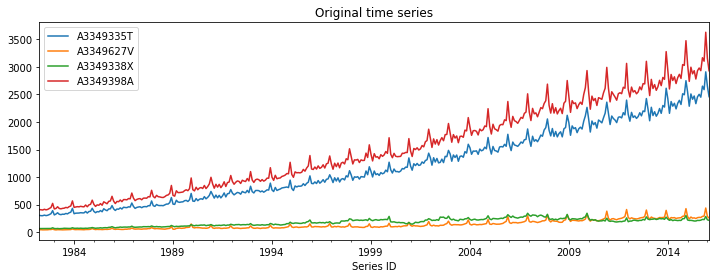

In [4]:
train_bound = pd.Timestamp('2016-02-01')
train = aus_retail[aus_retail.index <= train_bound].iloc[:, :4]
test = aus_retail[aus_retail.index > train_bound].iloc[:, :4]
train.plot(figsize=(12, 4))
plt.title('Original time series')
plt.show()

### Min max scaler

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((1, 2))
scaler.fit(train.values)
values = scaler.transform(train.values)
t_train = train.copy()
for i, col in enumerate(t_train.columns):
    t_train[col] = values[:, i]
t_train.head()

,A3349335T,A3349627V,A3349338X,A3349398A
Series ID,,,,
1982-04-01,1.002028,1.006035,1.007140,1.002385
1982-05-01,1.000000,1.009555,1.007497,1.001208
1982-06-01,1.000077,1.002514,1.002856,1.000000
1982-07-01,1.003866,1.004023,1.013210,1.004150
1982-08-01,1.000536,1.007040,1.002499,1.000867


In [6]:
import requests
url = 'https://raw.githubusercontent.com/vpozdnyakov/probabilistic_forecasting/main/models/TCN.py'
open('TCN.py', 'wb').write(requests.get(url).content);

In [28]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, RMSprop
from torch.autograd import Variable
from TCN import TCNModule, ResidualBlock

from IPython.display import clear_output

In [29]:
device = 'cuda'

In [30]:
train_torch = []
for i in range(t_train.shape[0] - 180 + 1):
    train_torch.append(t_train.iloc[i:i+180].values)
train_torch = torch.Tensor(train_torch).to('cuda')
train_torch.shape

torch.Size([228, 180, 4])

In [31]:
class TCNGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.z_conv = ResidualBlock(
            num_filters=16, kernel_size=2, dilation_base=2, 
            dropout_fn=nn.Dropout(p=0.2), weight_norm=True, 
            nr_blocks_below=0, num_layers=0, input_size=16, target_size=16)
        self.inp_conv = ResidualBlock(
            num_filters=16, kernel_size=2, dilation_base=2, 
            dropout_fn=nn.Dropout(p=0.2), weight_norm=True, 
            nr_blocks_below=0, num_layers=0, input_size=4, target_size=16)
        self.tcn = TCNModule(
            input_size=16, input_chunk_length=120, 
            kernel_size=2, num_filters=16, 
            num_layers=4, dilation_base=2, 
            weight_norm=True, target_size=4, 
            target_length=120, dropout=0.2)
    def forward(self, x, z):
        h = self.z_conv(z.transpose(1,2)) + self.inp_conv(x.transpose(1,2))
        return self.tcn(h.transpose(1,2))

In [47]:
class TCNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.tcn = TCNModule(
            input_size=4, input_chunk_length=180, 
            kernel_size=2, num_filters=16, 
            num_layers=2, dilation_base=2, 
            weight_norm=True, target_size=4, 
            target_length=180, dropout=0.2)
        self.dense = nn.Linear(180, 1)
    def forward(self, x):
        return self.tcn(x)

In [48]:
gen = TCNGenerator().to(device)
disc = TCNDiscriminator().to(device)

In [49]:
logs = []

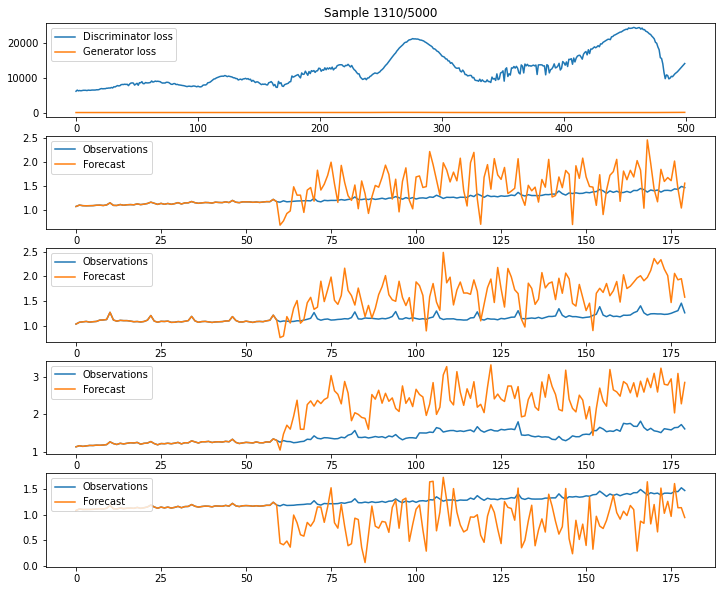

In [ ]:
gen_opt = Adam(gen.parameters(), lr=0.0001)
disc_opt = Adam(disc.parameters(), lr=0.0005)

gen.train()
n_samples = 5000
batch_size = 68
for s in range(n_samples):
    idx = np.random.choice(np.arange(train_torch.shape[0]), size=batch_size)
    real_x = train_torch[idx]
    cond_x = real_x[:, 0:120]
    z = torch.randn(batch_size, 120, 16, device=device)
    fake_x = torch.cat([cond_x[:, 0:60], gen(cond_x, z)], dim=1)

    lambd = 2
    eps = np.random.rand()
    unif_x = Variable(eps * real_x + (1 - eps) * fake_x, requires_grad=True)
    disc(unif_x).sum().backward()
    grad_penalty = torch.norm(unif_x.grad, p=2)
    
    disc_loss = disc(fake_x).mean() - disc(real_x).mean() + lambd * grad_penalty

    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()

    z = torch.randn(batch_size, 120, 16, device=device)
    fake_x = torch.cat([cond_x[:, 0:60], gen(cond_x, z)], dim=1)

    gen_loss = -disc(fake_x).mean()

    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()

    logs.append([disc_loss.item(), gen_loss.item()])
    assert not np.isnan(logs[-1]).max()

    if s % 10 == 0:
        plt.figure(figsize=(12, 2*5))
        plt.subplot(5, 1, 1)
        plt.plot(logs[-500:])
        plt.legend(['Discriminator loss', 'Generator loss'], loc='upper left')
        plt.title('Sample {}/{}'.format(s, n_samples))
        obs = real_x[0].cpu().detach().numpy()
        forecast = fake_x[0].cpu().detach().numpy()
        for i in range(4):
            plt.subplot(5, 1, i+2)
            plt.plot(np.arange(180), obs[:, i], label='Observations')
            plt.plot(np.arange(180), forecast[:, i], label='Forecast')
            plt.legend(loc='upper left')
        plt.show()
        clear_output(wait=True)

In [ ]:
torch.save(gen, 'gen.model')
torch.save(disc, 'disc.model')

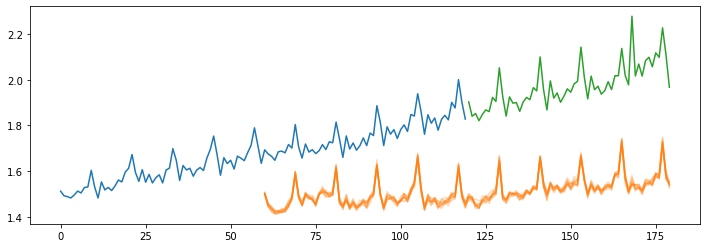

In [ ]:
gen.eval()
plt.figure(figsize=(12, 4))
i=0
cond_x = train_torch[[-1], -120:]
plt.plot(np.arange(120), cond_x[0, :, i].detach().cpu().numpy())
with torch.no_grad():
    for _ in range(10):
        z = torch.randn(1, 120, 16, device=device)
        #z = torch.zeros_like(z)
        plt.plot(
            np.arange(60, 180), 
            gen(cond_x, z)[0, :, i].detach().cpu().numpy(), 
            color='tab:orange', alpha=0.3)
plt.plot(np.arange(120, 180), scaler.transform(test.values)[:, i], color='tab:green');

In [ ]:
gen.eval()
with torch.no_grad():
    forecasts = []
    for _ in range(100):
        z = torch.randn(1, 120, 16, device=device)
        cond_x = train_torch[-1:, -120:]
        forecasts.append(gen(cond_x, z)[:, -60:])
    forecasts = torch.cat(forecasts).cpu().numpy()
proba_forecast = np.quantile(forecasts, q=[0.025, 0.5, 0.975], axis=0)
lower_forecast = scaler.inverse_transform(proba_forecast[0])
point_forecast = scaler.inverse_transform(proba_forecast[1])
upper_forecast = scaler.inverse_transform(proba_forecast[2])

In [ ]:
pred = pd.DataFrame(
    point_forecast, columns=test.columns, index=test.index)
lower = pd.DataFrame(
    lower_forecast, columns=test.columns, index=test.index)
upper = pd.DataFrame(
    upper_forecast, columns=test.columns, index=test.index)

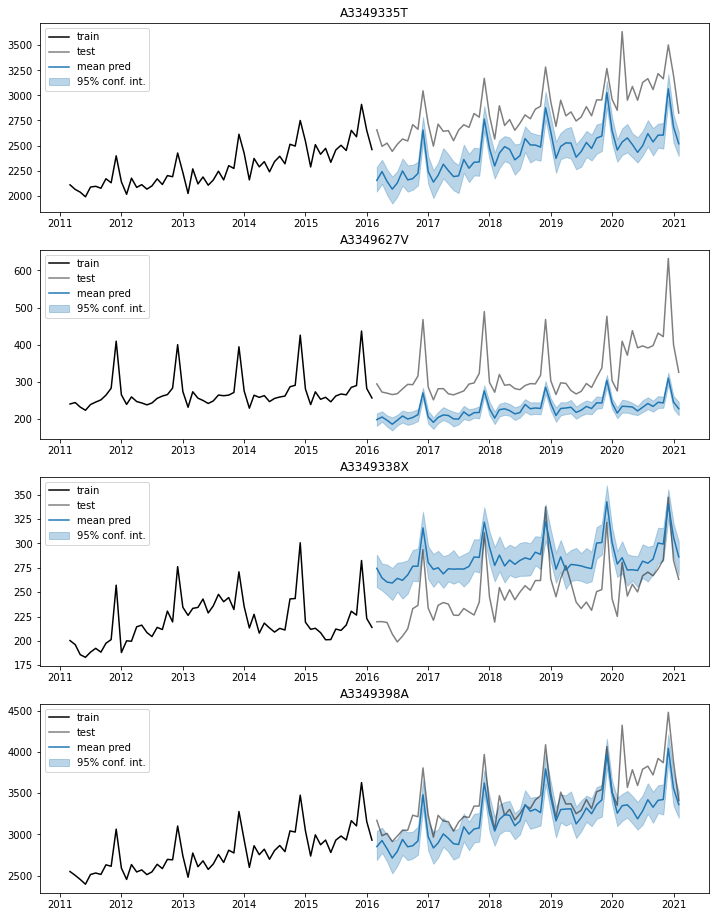

In [ ]:
plt.figure(figsize=(12, 4*4))
for i, col in enumerate(train.columns):
    plt.subplot(4, 1, i+1)
    plt.plot(train[col].iloc[-60:], c='black', label='train')
    plt.plot(test[col], c='black', label='test', alpha=0.5)
    plt.plot(pred[col], c='tab:blue', label='mean pred')
    plt.fill_between(pred.index, lower[col], upper[col], 
                     color='tab:blue', alpha=0.3, label='95% conf. int.')
    plt.legend(loc='upper left')
    plt.title(col)